In [2]:
## ---- Partition Cell Set Network Module Analysis ---- 0670.00.00
## Load Analysis Parameters (Parm1)
## Load Network Utilities
## Loop Through Each Partition and Perform Analysis as Follows:
## Load Partition Cell Set
## Load Large 50,000 Edge Networks Created in 0620.00.00.Carotid.SC.NotebookPartitionAnalysisNetwork.B.01.ipynb0620.00.00
## Cut networks to 20,000 edges
## Create Clusters Using Recursive Louvain (Rev 2 plots use weight = pcor, Rev1 plots use 1/pcor)
## Plot the Network with Clusters (20,000 Edges Each)
## The following items will be performed in another notebook
## Perform Module GO Enrichment Analysis on Selected Clusters (topGO, with Tables and GO Plots)
## Note: Use GO Biological Process Terms for Enrichment Analysis
## Save Module Analysis Results to 'Modules.20000' Directory 

In [401]:
## Create a Working Input and Output Data Directory, If Id Does Not Exist
parentdir <- '/gpfs/group/torkamani/devans/'
datdir <- paste(parentdir, 'CDC2', sep = '')
if (!file.exists(datdir)) {
    dir.create(datdir)
}
setwd(datdir)

In [4]:
## Read the parameters file
ps <- read.table(file = 'parms.txt', stringsAsFactors = FALSE, header = TRUE)

In [5]:
## Read the GENCODE v27 Data
v27_gen <- read.table(paste(ps$indir, 'v27_Embl_Hugo.txt', sep = ''), header = F)
v27_gen[,1] <- substr(v27_gen[,1] ,1, 15)
v27 <- read.table(paste(ps$indir, 'v27_Embl_Hugo_Type.txt', sep =''))

In [391]:
## Load Monocle3 and Seurat Libraries
library(monocle3)
library(Seurat)
library(dplyr)
library(magrittr)
library(ggplot2)
library(gridExtra)
library(Matrix)
library(rhdf5)
library(grid)
library(igraph)
library(corpcor)
library(fdrtool)
library(tidyverse)
library(repr)

## Get the igraph utilities
source('/gpfs/home/devans/code/Utilities/fromSara/setup_igraph.r')
source('/gpfs/home/devans/code/Utilities/fromSara/recursive_louvain.r')
source('/gpfs/home/devans/code/Utilities/fromSara/cluster_score.r')
source('/gpfs/home/devans/code/Utilities/fromSara/cluster_overlap.r')
source('/gpfs/home/devans/code/Utilities/fromSara/plot_by_cluster.r')

## Alternate to stat_parm utility in igraph utilities (does not assume log10 data)
stat_parm2 <- function(gf, expdata){
    
    ## Remove expression values not in the network, get antilog
    # expdata_filt <- 10 ^ log10expdata[,V(gf)$name]
    expdata_filt <- expdata[,V(gf)$name]
    
    ## Compute the node expression stats, including coeff of variation, add to network
    V(gf)$mean <- apply(expdata_filt, 2, mean)
    V(gf)$sd <- apply(expdata_filt, 2, sd)
    V(gf)$cv <- V(gf)$sd/V(gf)$mean
    V(gf)$med <- apply(expdata_filt, 2, median)

    ## Compute the strength
    V(gf)$strength <- strength(gf, weights = abs(E(gf)$pcor))
    return(gf)
    }
## Alternate to plot function in utility

plot_parm2 <- function (gf) {

    V(gf)$color <- 'red'
    
    E(gf)$color[E(gf)$pcor > 0] <- 'green'
    E(gf)$color[E(gf)$pcor < 0] <- 'orange'
    fedthick <- 100 * abs(E(gf)$pcor)
    V(gf)$label.cex = .1
    E(gf)$label.cex = .1
    V(gf)$label <- paste(substr(V(gf)$v27,1,10),
                                   round(V(gf)$strength,3), sep = '\n')
    E(gf)$width <- fedthick
    E(gf)$label <- round(E(gf)$pcor, 4)
    V(gf)$size <- 1

    return(gf)
    }

In [8]:
## Read the previously preprocessed downsampled cell set data object
down_stdycds <- readRDS(file = paste(ps$outdir,
            'Aggregated.downsampled.QC.NoDoublets.Repartitioned.rds', sep = ''))

In [9]:
## Build a gene short name to gene id (Ensembl) lookup
short2geneid <- fData(down_stdycds)@rownames
names(short2geneid) <- fData(down_stdycds)@listData$gene_short_name

In [10]:
## Build a gene id (Ensembl) to gene short name lookup
geneid2short <- fData(down_stdycds)@listData$gene_short_name
names(geneid2short) <- fData(down_stdycds)@rownames

In [11]:
## Create variables for how cells sets are organized
cellgrps <- c('healthy', 'diseased', 'healthy', 'diseased', 'healthy', 'diseased')
cellpats <- c('ID Number 1', 'ID Number 1', 'ID Number 2', 'ID Number 2', 'ID Number 3', 'ID Number 3')

In [12]:
## Define and Assign Cell Types
celltypes6 <- c('1-Macrophages',
                '2-Endothelial Cells',
                '3-VSMCs',
                '4-Natural Killer Cells',
                '5-Cytotoxic T Lymphocytes',
                '6-B Lymphocytes')

In [13]:
## Declare Tom's best genes for definiting cell types
toms_markers5 <- c('NRXN1', 'CLU', 'ICAM2',
                 'CD14', 'CD68', 'AIF1',
                 'VWF', 'EDN1', 'ECSCR',
                 'MKI67', 'UBE2C', 'TOP2A',
                 'ACTA2', 'TAGLN', 'MYL9',
                 'ACKR1', 'SPARCL1', 'PECAM1',
                 'CALD1', 'MGP', 'DCN',
                 'NKG7', 'XCL1', 'CTSW',
                 'CD8A', 'TRAC', 'CD2',
                 'MS4A1', 'CD79A', 'BANK1',
                 'CD69', 'CXCR4', 'IL7R',
                 'LILRA4', 'IRF7', 'CLEC4C',
                 'MZB1', 'JCHAIN', 'TNFRSF17',
                 'LST1', 'FCGR3B', 'S100A8',
                 'TPSAB1', 'CPA3', 'MS4A2')
toms_gene_ids5 <- short2geneid[toms_markers5]


doug_markers1 <- c('AIF1', 'LYZ', 'FCER1G',  'CD68',
                'RNASE1', 'PECAM1', 'IGFBP4', 'ADIRF', 
                'SOD3', 'MYL9', 'CALD1', 'GSN',
                'TYROBP', 'NKG7', 'CTSW', 'CD69',
                'CD3D', 'CD2', 'TRBC2', 'TRAC',
                'MS4A1', 'CD79A', 'HLA-DQA1', 'CD37')
dougs_gene_ids1 <- short2geneid[doug_markers1]

In [61]:
## Loop through the partitions and perform analysis, making networks
## Determine the number of partitions
np <- length(celltypes6)
## When trimming, decomposing, or re-aggregating the network,
## what are the fewest edges of subnets to re-aggregate
min_edges <- 4
diff_exp_qval_cut <- 0.05    # Differential Expression q-value cutoff for displaying on graph
plotflag <- TRUE
edges_to_keep <- 20000
netstat_m <- NULL

for (p in 5:np) {
    setwd(paste(datdir, '/', ps$outdir, celltypes6[p], sep = ''))
    
    ## Read partition cell data set, expression data, and diff expression data
    partn_cds <- readRDS('Partition.Cell.Set.rds')
    partn_exp <- t(exprs(partn_cds))
    if (file.exists('Diff.AllHealthCoeff.RemoveFail.NoModels.txt'))  {   
        de_tab <- read.table('Diff.AllHealthCoeff.RemoveFail.NoModels.txt', header = TRUE,
                             stringsAsFactors = FALSE)    
    }
    
    ## Read the saved network
    net2 <- readRDS('Network.50000.rds')
    
    ## Remove the singleton nodes
    net2 <- delete_vertices(net2, v = V(net2)$name[degree(net2) == 0])
    
    # Remove the small disconnected modules
    dcomp <- decompose(net2, min.vertices = 0)
    merge_cnt <- 0
    del_edges <- NULL
    for (i in 1:length(dcomp)) {
        if (length(E(dcomp[[i]])$pcor) < min_edges) {
            del_edges <- c(del_edges, V(dcomp[[i]])$name )
            merge_cnt <- merge_cnt + 1
            # print(merge_cnt)
        }
    }
    net2 <- delete_vertices(net2, v = del_edges)

    # print(paste(celltypes6[p], ': genes = ', length(V(net2)$name),
    # ', edges = ', length(E(net2)$pcor), sep = ''))
    
    ## Plot the Large 50,000 Edge Network Stats
    plotfp <- 'Network.Stats.qvalue.To.Edgecount.50000.Rev1.pdf'     
    pdf(plotfp, width = 10, height = 10)
        thresh = 1E-1
        vline = which(sort(E(net2)$qval > thresh))[1]
        g1 <- plot(x = log10(1:length(E(net2)$qval)), y = -log10(sort(E(net2)$qval)),
            xlab = 'log10(number of edges)', ylab = '-log10(edge q-value)', pch = 20, col = 'blue',
            main = paste('Network q-values Verses Number of Edges\n', 
            '(there are ', vline, ' edges with a q-value threshold below ', thresh, ')', sep = ''))
        g1 <- g1 + abline(h = 1, col = 'red')
        g1 <- g1 + abline(v = log10(vline), col = 'red')
        g1 <- g1 + grid()
    dev.off()
    
    ## Delete Sufficient Edges to Get Down to 20,000, and then removed singletons
    p_value_cutoff_deletion <- sort(E(net2)$pval, decreasing = FALSE)[edges_to_keep]
    net2 <- delete_edges(net2, edges = E(net2)[!(E(net2)$pval <= p_value_cutoff_deletion)]) 
    
    ## Remove the singleton nodes
    net2 <- delete_vertices(net2, v = V(net2)$name[degree(net2) == 0]) 
    
    # Remove the small disconnected modules
    dcomp <- decompose(net2, min.vertices = 0)
    merge_cnt <- 0
    del_edges <- NULL
    for (i in 1:length(dcomp)) {
        if (length(E(dcomp[[i]])$pcor) < min_edges) {
            del_edges <- c(del_edges, V(dcomp[[i]])$name )
            merge_cnt <- merge_cnt + 1
            # print(merge_cnt)
        }
    }
    net2 <- delete_vertices(net2, v = del_edges)
    
    if (plotflag) {
        ## Get the FDR socres
        fdr_cut <- readRDS('FDR_CUT.50000.rds')
    

        V(net2)$v27 <- as.vector(v27_gen[match(V(net2)$name, v27_gen[,1]),2])
        # Lookup the HUGO gene names and types for the network nodes
        hv27types <- as.vector(v27[match(V(net2)$name, substr(v27[,1],1,15)),3])
        # Save the gene types for V27 as attributes in the network
        V(net2)$v27type <- hv27types
        ## Set the weight equal to the recipicol of the absolute pcor values
        ## This is an interpretation of weight = closer (larger values are closer nodes)
        E(net2)$weight <- abs(E(net2)$pcor)
        ## add degree and stength node attributes
        V(net2)$strength <- strength(net2, weights = abs(E(net2)$pcor))
        V(net2)$degree <- degree(net2, normalized = TRUE)
        net2 <- stat_parm(net2, partn_exp)  
        V(net2)$gene <- V(net2)$name
        ## Get the annotation information, force single tissue (cell type)
        net2 <- annot_parm(net2)
        ## Get the plot information
        net2 <- plot_parm2(net2)  
        
        ## This was mistakenly used in the pcor = 1E-1 dense plot
        net2_clust <- cluster_louvain(net2)
        clust_sc <- cluster_score(net2, clusters = membership(net2_clust), sizes = TRUE, max.str = TRUE)
    
#         ## The other cluster option to consider using
#         net2_reclust <- recursive_louvain(net2, biggest = 150)
#         reclust_sc <- cluster_score(net2, clusters = net2_reclust, sizes = TRUE, max.str = TRUE)
        
        ## Get the significant differential expressed terms
        qsig <- de_tab %>% filter(q_value < diff_exp_qval_cut) %>% 
            dplyr::select(gene_short_name, normalized_effect, q_value)
    
        ## If there are any significant DE genes, colorize them in the network
        V(net2)$color <- rgb(0, 0, 1, alpha = .75)
        valid_de <- dim(qsig)[1]
        if (valid_de >= 1) {
            gene2ne <- qsig$normalized_effect
            names(gene2ne) <- qsig$gene_short_name
            gene2ne <- gene2ne/max(abs(gene2ne))
            gene2ne_p <- round(gene2ne[gene2ne > 0], 3)
            gene2ne_m <- round(-gene2ne[gene2ne < 0], 3)
            V(net2)$color <- rgb(0, 0, 1, alpha = .75)
            V(net2)$color[V(net2)$v27 %in% names(gene2ne_p)] <- 
                rgb(1, gene2ne_p[names(gene2ne_p) %in% V(net2)$v27], 
                    gene2ne_p[names(gene2ne_p) %in% V(net2)$v27], alpha = .5)
            V(net2)$color[V(net2)$v27 %in% names(gene2ne_m)] <- 
                rgb(gene2ne_m[names(gene2ne_m) %in% V(net2)$v27], 1,
                    gene2ne_m[names(gene2ne_m) %in% V(net2)$v27], alpha = .5)   
        }
        
        ## Save everything before plotting    
        saveRDS(net2, 'Network.20k.rds')
        saveRDS(net2_clust, 'Louvain.Clust.20k.rds')
        saveRDS(clust_sc, 'Louvain.Clust.Score.20k.rds')
#         saveRDS(net2_reclust, 'Recuvsive.Louvain.Clust.20k.rds')
#         saveRDS(reclust_sc, 'Recursive.Louvain.Clust.Score.20k.rds')        

    plot_by_cluster(graph = net2, clusts = membership(net2_clust), scores = clust_sc,
            mode = c('number','cutoff','specify')[2],
            numclusts = 5, minscore = .01, specifyclusts = c(1,3,5,9), crosses = TRUE,
            filename = 'Dense.20k.Network.Rev2.wCrosses.pdf')
    
    plot_by_cluster(graph = net2, clusts = membership(net2_clust), scores = clust_sc,
            mode = c('number','cutoff','specify')[2],
            numclusts = 5, minscore = .01, specifyclusts = c(1,3,5,9), crosses = FALSE,
            filename = 'Dense.20k.Network.Rev2.woCrosses.pdf')
    }
}

In [62]:
p

[1] 6

In [14]:
plot_by_cluster <- function (graph, clusts, scores, mode = c("number", "cutoff", 
    "specify"), numclusts = 5, minscore = 0.3, specifyclusts = c(1, 
    3, 5, 9), crosses = FALSE, filename = "/gpfs/group/torkamani/devans/GTEx/Data.Work.Area.2/xTissue/Unorganized/plot_by_clusts.pdf") 
{
    if (identical(mode, "number")) {
        orderscore <- scores[order(scores$score, decreasing = TRUE), 
            ]
        topclusts <- as.numeric(sort(rownames(orderscore[1:numclusts, 
            ])))
        selectednames <- names(clusts[clusts %in% topclusts])
        subgraph <- induced_subgraph(graph, V(graph)$name %in% 
            selectednames)
    }
    if (identical(mode, "cutoff")) {
        orderscore <- scores[order(scores$score, decreasing = TRUE), 
            ]
        topclusts <- as.numeric(sort(rownames(orderscore[orderscore$score >= 
            minscore, ])))
        selectednames <- names(clusts[clusts %in% topclusts])
        subgraph <- induced_subgraph(graph, V(graph)$name %in% 
            selectednames)
    }
    if (identical(mode, "specify")) {
        orderscore <- scores[order(scores$score, decreasing = TRUE), 
            ]
        wantedclusts <- as.numeric(sort(specifyclusts))
        selectednames <- names(clusts[clusts %in% wantedclusts])
        subgraph <- induced_subgraph(graph, V(graph)$name %in% 
            selectednames)
    }
    rlcommunities <- create.communities(subgraph, membership = clusts[names(clusts) %in% 
        selectednames])
    lt <- layout_with_dh
    clust_temp <- rlcommunities
    graph_temp <- delete.edges(subgraph, E(subgraph)[crossing(clust_temp, 
        subgraph)])
    set.seed(103)
    graph_lo <- layout_components(graph_temp, layout = lt)
    graph_lo <- layout.norm(graph_lo, -1, 1, -1, 1)
    mxscale <- max(V(graph_temp)$strength)
    cl <- V(graph_temp)$strength/mxscale
    pcnodes <- which(V(graph_temp)$v27type == "protein_coding")
    npcnodes <- which(V(graph_temp)$v27type != "protein_coding")
    pccol <- rgb(1, 0, 0, alpha = 0.75)
    npccol <- rgb(0, 1, 0, alpha = 0.75)
    node_frames_cols <- vector(mode = "character", length = length(pcnodes))
    node_frames_cols[pcnodes] <- pccol
    node_frames_cols[npcnodes] <- npccol
    nodelabc <- rgb(0, 0, 1, alpha = 0.4)
    polycol <- rgb(0, 1, 1, alpha = 0)
    node_frames_cols <- node_frames_cols[node_frames_cols != 
        ""]
    clust_temp2 <- clust_temp
    numcl <- length(unique(membership(clust_temp)))
    clustname <- sort(unique(membership(clust_temp)))
    for (i in 1:numcl) {
        clust_temp2$membership[clust_temp2$membership == clustname[i]] <- i
    }
    ctxtpos <- matrix(0, nrow = numcl, ncol = 2)
    colnames(ctxtpos) <- c("x", "y")
    for (i in 1:numcl) {
        ctxtpos[i, "x"] <- max(graph_lo[membership(clust_temp2) == 
            i, 1])
        ctxtpos[i, "y"] <- mean(graph_lo[membership(clust_temp2) == 
            i, 2])
    }
    V(graph_temp)$label.cex = 0.1
    E(graph_temp)$label.cex = 0.1
    if (crosses) {
        plotvar <- subgraph
    }
    else {
        plotvar <- graph_temp
    }
    pdf(filename, width = 30, height = 30)
    plot(plotvar, layout = graph_lo, mark.groups = clust_temp2, 
        mark.shape = 1, mark.expand = 1.5, mark.col = polycol, 
        vertex.frame.color = node_frames_cols, vertex.shape = "circle", 
        edge.width = 20 * abs(E(subgraph)$pcor), vertex.size = 0.6, 
        main = "Partial Correlation Network\nRecursive Louvain")
    legend(x = -0.85, y = -0.85, legend = c("Protein Coding biotype genes have Red Frames", 
        "All Other biotype genes have Green Frames", "Nodes Shaded Blue Are Not Effected By Disease State", 
        "Red Is Healthy, Green Is Diseased", "Strength Shown Below Gene Name in Each Node"), 
        col = "black")
    text(x = ctxtpos[, 1], y = ctxtpos[, 2], adj = c(0, 0), paste("cluster = ", 
        clustname, sep = ""), cex = 0.5, col = nodelabc, font = 4)
    text(x = ctxtpos[, 1], y = ctxtpos[, 2] - 0.006, adj = c(0, 
        0), paste("score = ", round(scores[as.character(clustname), 
        ]$score, digits = 2), sep = ""), cex = 0.5, col = nodelabc, 
        font = 4)
    text(x = ctxtpos[, 1], y = ctxtpos[, 2] - 0.012, adj = c(0, 
        0), paste("max strength = ", round(scores[as.character(clustname), 
        ]$max.str, digits = 2), sep = ""), cex = 0.5, col = nodelabc, 
        font = 4)
    dev.off()
}

In [ ]:
## Added section below: 12/10/2020

In [14]:
p <- 3
setwd(paste(datdir, '/', ps$outdir, celltypes6[p], sep = ''))
    
## Read partition cell data set, expression data, and diff expression data
partn_cds <- readRDS('Partition.Cell.Set.rds')
# partn_cds <- partn_cds[, colData(partn_cds)$condition == 'diseased']
partn_exp <- t(exprs(partn_cds))

In [15]:
table(colData(partn_cds)$condition)


diseased  healthy 
    1223     2449 

In [16]:
# ## Get the expression vectors from the original and depleted cell sets (healthy)
# gene <- short2geneid[gene_hugo]
# gene <- which(genes == gene)
# cat('HGNC to EMBL, ', gene_hugo, ' <--> ', genes[gene], '\n', sep = '')
# orginal <- exprs(heamcds)[gene, bc1]
# depleted <- exprs(heamcds)[gene, bc2]

In [17]:
gene1 <- 'C3'
gene2 <- 'ATF3'
geneid1 <- short2geneid[gene1]
geneid2 <- short2geneid[gene2]
gene1exp <- partn_exp[, geneid1]
gene2exp <- partn_exp[, geneid2]
t <- table(gene1exp, gene2exp)

In [18]:
# ## Set up to plot confusion matrix
# t <- table(orginal, depleted)
# dep_counts <- as.integer(colnames(t))
# dep_len <- length(dep_counts)
# org_counts <- as.integer(rownames(t))
# org_len <- length(org_counts)
# conf_xyz <- matrix(integer(0), nrow = dep_len * org_len, ncol = 3)
# colnames(conf_xyz) <- c('x', 'y', 'exprs')
# pos <- 1
# for (i in 1:org_len) {
#     for (j in 1:dep_len) {
#         conf_xyz[pos, 'x'] <- org_counts[i]
#         conf_xyz[pos, 'y'] <- dep_counts[j]
#         conf_xyz[pos, 'exprs'] <- t[i,j]
#         pos <- pos + 1
#     }
# }

In [19]:
## Set up to plot confusion matrix
# t <- conf_mat
gene2_counts <- as.integer(colnames(t))
gene2_len <- length(gene2_counts)
gene1_counts <- as.integer(rownames(t))
gene1_len <- length(gene1_counts)
conf_xyz <- matrix(integer(0), nrow = gene2_len * gene1_len, ncol = 3)
colnames(conf_xyz) <- c('x', 'y', 'exprs')
pos <- 1
for (i in 1:gene1_len) {
    for (j in 1:gene2_len) {
        conf_xyz[pos, 'x'] <- gene1_counts[i]
        conf_xyz[pos, 'y'] <- gene2_counts[j]
        conf_xyz[pos, 'exprs'] <- t[i,j]
        pos <- pos + 1
    }
}

[1] 1465

[1] 0

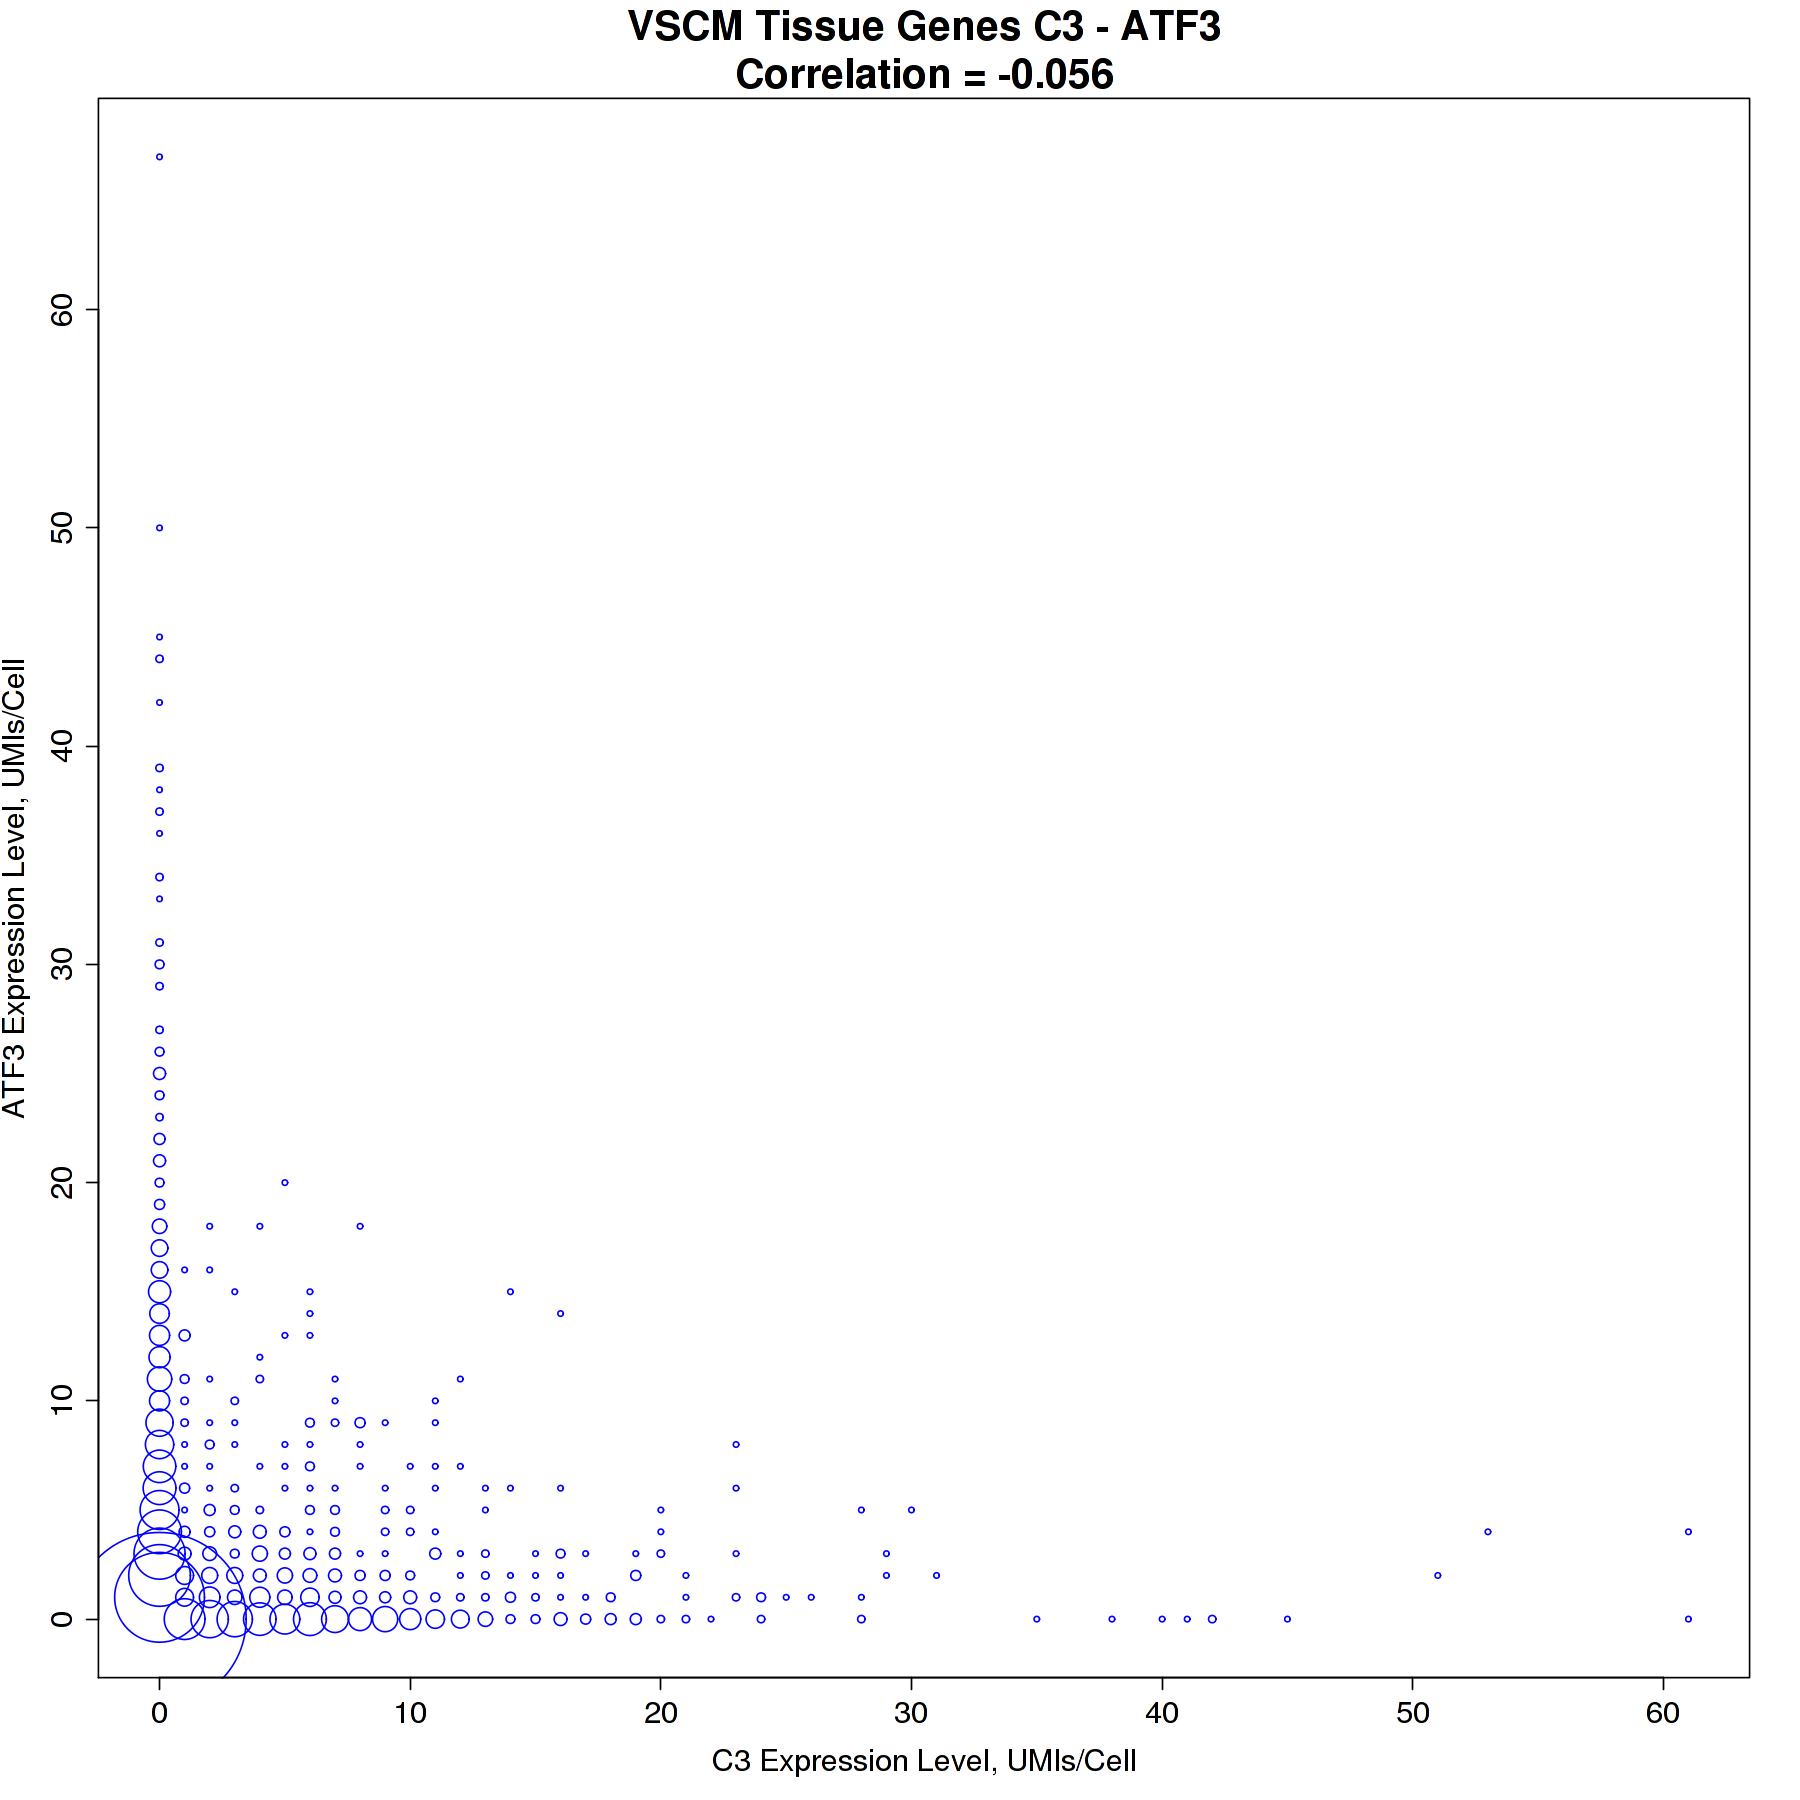

In [20]:
## Plot the confusion matrix as a scatter plot, with dot size = cell count

# orginal <- gene2exp
# depleted <- gene1exp
gene_hugo <- paste(gene1, gene2, sep = ' - ')
he <- max(conf_xyz[, 'exprs'])
ms <- min(conf_xyz[, c('x', 'y')])
he
ms
sf <- .5 # 100/he  # * ms / 40                
# exprs_mdl <- lm(gene2exp ~ gene1exp + 0)
# exprs_mdl <- lm(conf_xyz[, 1] ~ conf_xyz[, 2], weights = conf_xyz[, 3])
# table_mdl <- lm(conf_xyz[, 1] ~ conf_xyz[, 2] + 0, weights = conf_xyz[, 3]) # Produces the same model as above
cor1_2 <- cor(gene1exp, gene2exp)
options(repr.plot.width=15, repr.plot.height=15)
## Use the square root of expression to set plot dot size for expression to be proportional to dot area
plot(x = conf_xyz[, 'x'], y = conf_xyz[, 'y'], type = 'p', cex = sf * conf_xyz[, 'exprs'] ^ .5,
     cex.main = 2, 
     col = 'blue', xlab = paste(gene1, 'Expression Level, UMIs/Cell', sep = ' '),
    ylab = paste(gene2, 'Expression Level, UMIs/Cell', sep = ' '), cex.axis=1.5, cex.lab = 1.5,
    main = paste('VSCM Tissue Genes ', gene_hugo, '\nCorrelation = ', round(cor1_2, 3), sep = ''))
# lines(x = conf_xyz[, 'x'], y = 1 / exprs_mdl$coefficients[1] * conf_xyz[, 'x'], col = 'red')

In [494]:
## Clean up the table and add a column for representing the expression data (dots) by size
#    conf_xyz_tbl <- as_tibble(conf_xyz) %>% filter(exprs > 0) %>%
#    mutate(logscaled_exp = 8 * (log10(conf_xyz_tbl$exprs)))

conf_xyz_tbl <- as_tibble(conf_xyz) %>% filter(exprs > 0)
conf_xyz_tbl <- conf_xyz_tbl %>% mutate(logscaled_exp = 8 * (log10(conf_xyz_tbl$exprs)))

#    mutate(logscaled_exp = 1 * conf_xyz_tbl$exprs)
max_x <- max(conf_xyz_tbl$x)
max_y <- max(conf_xyz_tbl$y)

In [489]:
str(conf_xyz_tbl)

tibble [221 × 4] (S3: tbl_df/tbl/data.frame)
 $ x            : int [1:221] 0 0 0 0 0 0 0 0 0 0 ...
 $ y            : int [1:221] 0 1 2 3 4 5 6 7 8 9 ...
 $ exprs        : int [1:221] 1465 390 182 124 90 71 50 49 37 34 ...
 $ logscaled_exp: num [1:221] 25.3 20.7 18.1 16.7 15.6 ...


In [490]:
# conf_xyz_tbl %>% filter(exprs > 0) %>% ggplot(aes(x = x, y = y, size = logscaled_exp, weight = exprs)) +
#     geom_point(shape = 21, fill = 'red', alpha = .25) + 
#     scale_size_identity(guide = 'legend', aesthetics = "fill") + 
#     geom_smooth(formula = y ~ x, method = glm) +
#     coord_cartesian(xlim = c(0, max_x), ylim = c(0, max_y)) +
#     scale_x_continuous(limits = c(0, max_x)) + scale_y_continuous(limits = c(0, max_y))

In [491]:
glmm <- glm(conf_xyz_tbl$y ~ conf_xyz_tbl$x, weights = conf_xyz_tbl$exprs)
glmm
corg1g2 <- cor.test(gene1exp, gene2exp)
corg1g2.e <- corg1g2$estimate
corg1g2.p <- corg1g2$p.value
glmtext <- paste('GL Model:\nSlope = ', round(glmm$coefficients[2], 4),
                 '\nIntercept = ', round(glmm$coefficients[1], 4),
                 '\nCorrelation = ', round(corg1g2.e, 4),
                 '\nCorrelation pval = ', round(corg1g2.p, 4), sep = '')
glmtext


Call:  glm(formula = conf_xyz_tbl$y ~ conf_xyz_tbl$x, weights = conf_xyz_tbl$exprs)

Coefficients:
   (Intercept)  conf_xyz_tbl$x  
       2.38310        -0.05975  

Degrees of Freedom: 220 Total (i.e. Null);  219 Residual
Null Deviance:	    86120 
Residual Deviance: 85850 	AIC: 1706

[1] "GL Model:\nSlope = -0.0598\nIntercept = 2.3831\nCorrelation = -0.0563\nCorrelation pval = 6e-04"

In [492]:
# ggplot(conf_xyz_tbl, aes(x = x, y = y, weight = exprs)) +
#     geom_point(shape = 21, fill = 'brown', alpha = .3, aes(size = logscaled_exp)) + 
#     scale_size_identity(guide = 'legend') + 
#     geom_smooth(formula = y ~ x, method = glm, color = rgb(0,0,1,.5)) +
#     coord_cartesian(xlim = c(-max_x/20, max_x), ylim = c(-max_y/20, max_y)) +
#     scale_x_continuous(limits = c(-max_x/20, max_x)) + scale_y_continuous(limits = c(-max_y/20, max_y)) +
#     labs(x = paste(gene1, '(UMIs per cell)', sep = ''),
#          y = paste(gene2, '(UMIs per cell)', sep = ''),
#          title = paste(gene1, ' to ', gene2 ,' Confusion Matrix', sep = '')) +
#     annotate(geom = 'text', x = 20, y = 40, label = glmtext,
#             color = "grey20", size = 7, angle = 0, hjust = 0, vjust = 0) +
#     guides(size = guide_legend(title="Log10 Number of Cells x8")) + 
#     theme(axis.text.x = element_text(color = "grey20", size = 20, angle = 90, hjust = .5, vjust = .5, face = "plain"),
#         axis.text.y = element_text(color = "grey20", size = 20, angle = 0, hjust = 1, vjust = 0, face = "plain"),  
#         axis.title.x = element_text(color = "grey20", size = 20, angle = 0, hjust = .5, vjust = 0, face = "plain"),
#         axis.title.y = element_text(color = "grey20", size = 20, angle = 90, hjust = .5, vjust = .5, face = "plain"),
#         plot.title = element_text(color = "grey20", size = 30, angle = 0, hjust = .5, vjust = 0, face = "plain"),
#         legend.text = element_text(color = "grey20", size = 15, angle = 0, hjust = 0, vjust = .5, face = "plain"),
#         legend.title = element_text(color = "grey20", size = 15, angle = 0, hjust = .5, vjust = 0, face = "plain"),
#         text = element_text(color = "grey20", size = 15, angle = 0, hjust = .5, vjust = 0, face = "plain"))


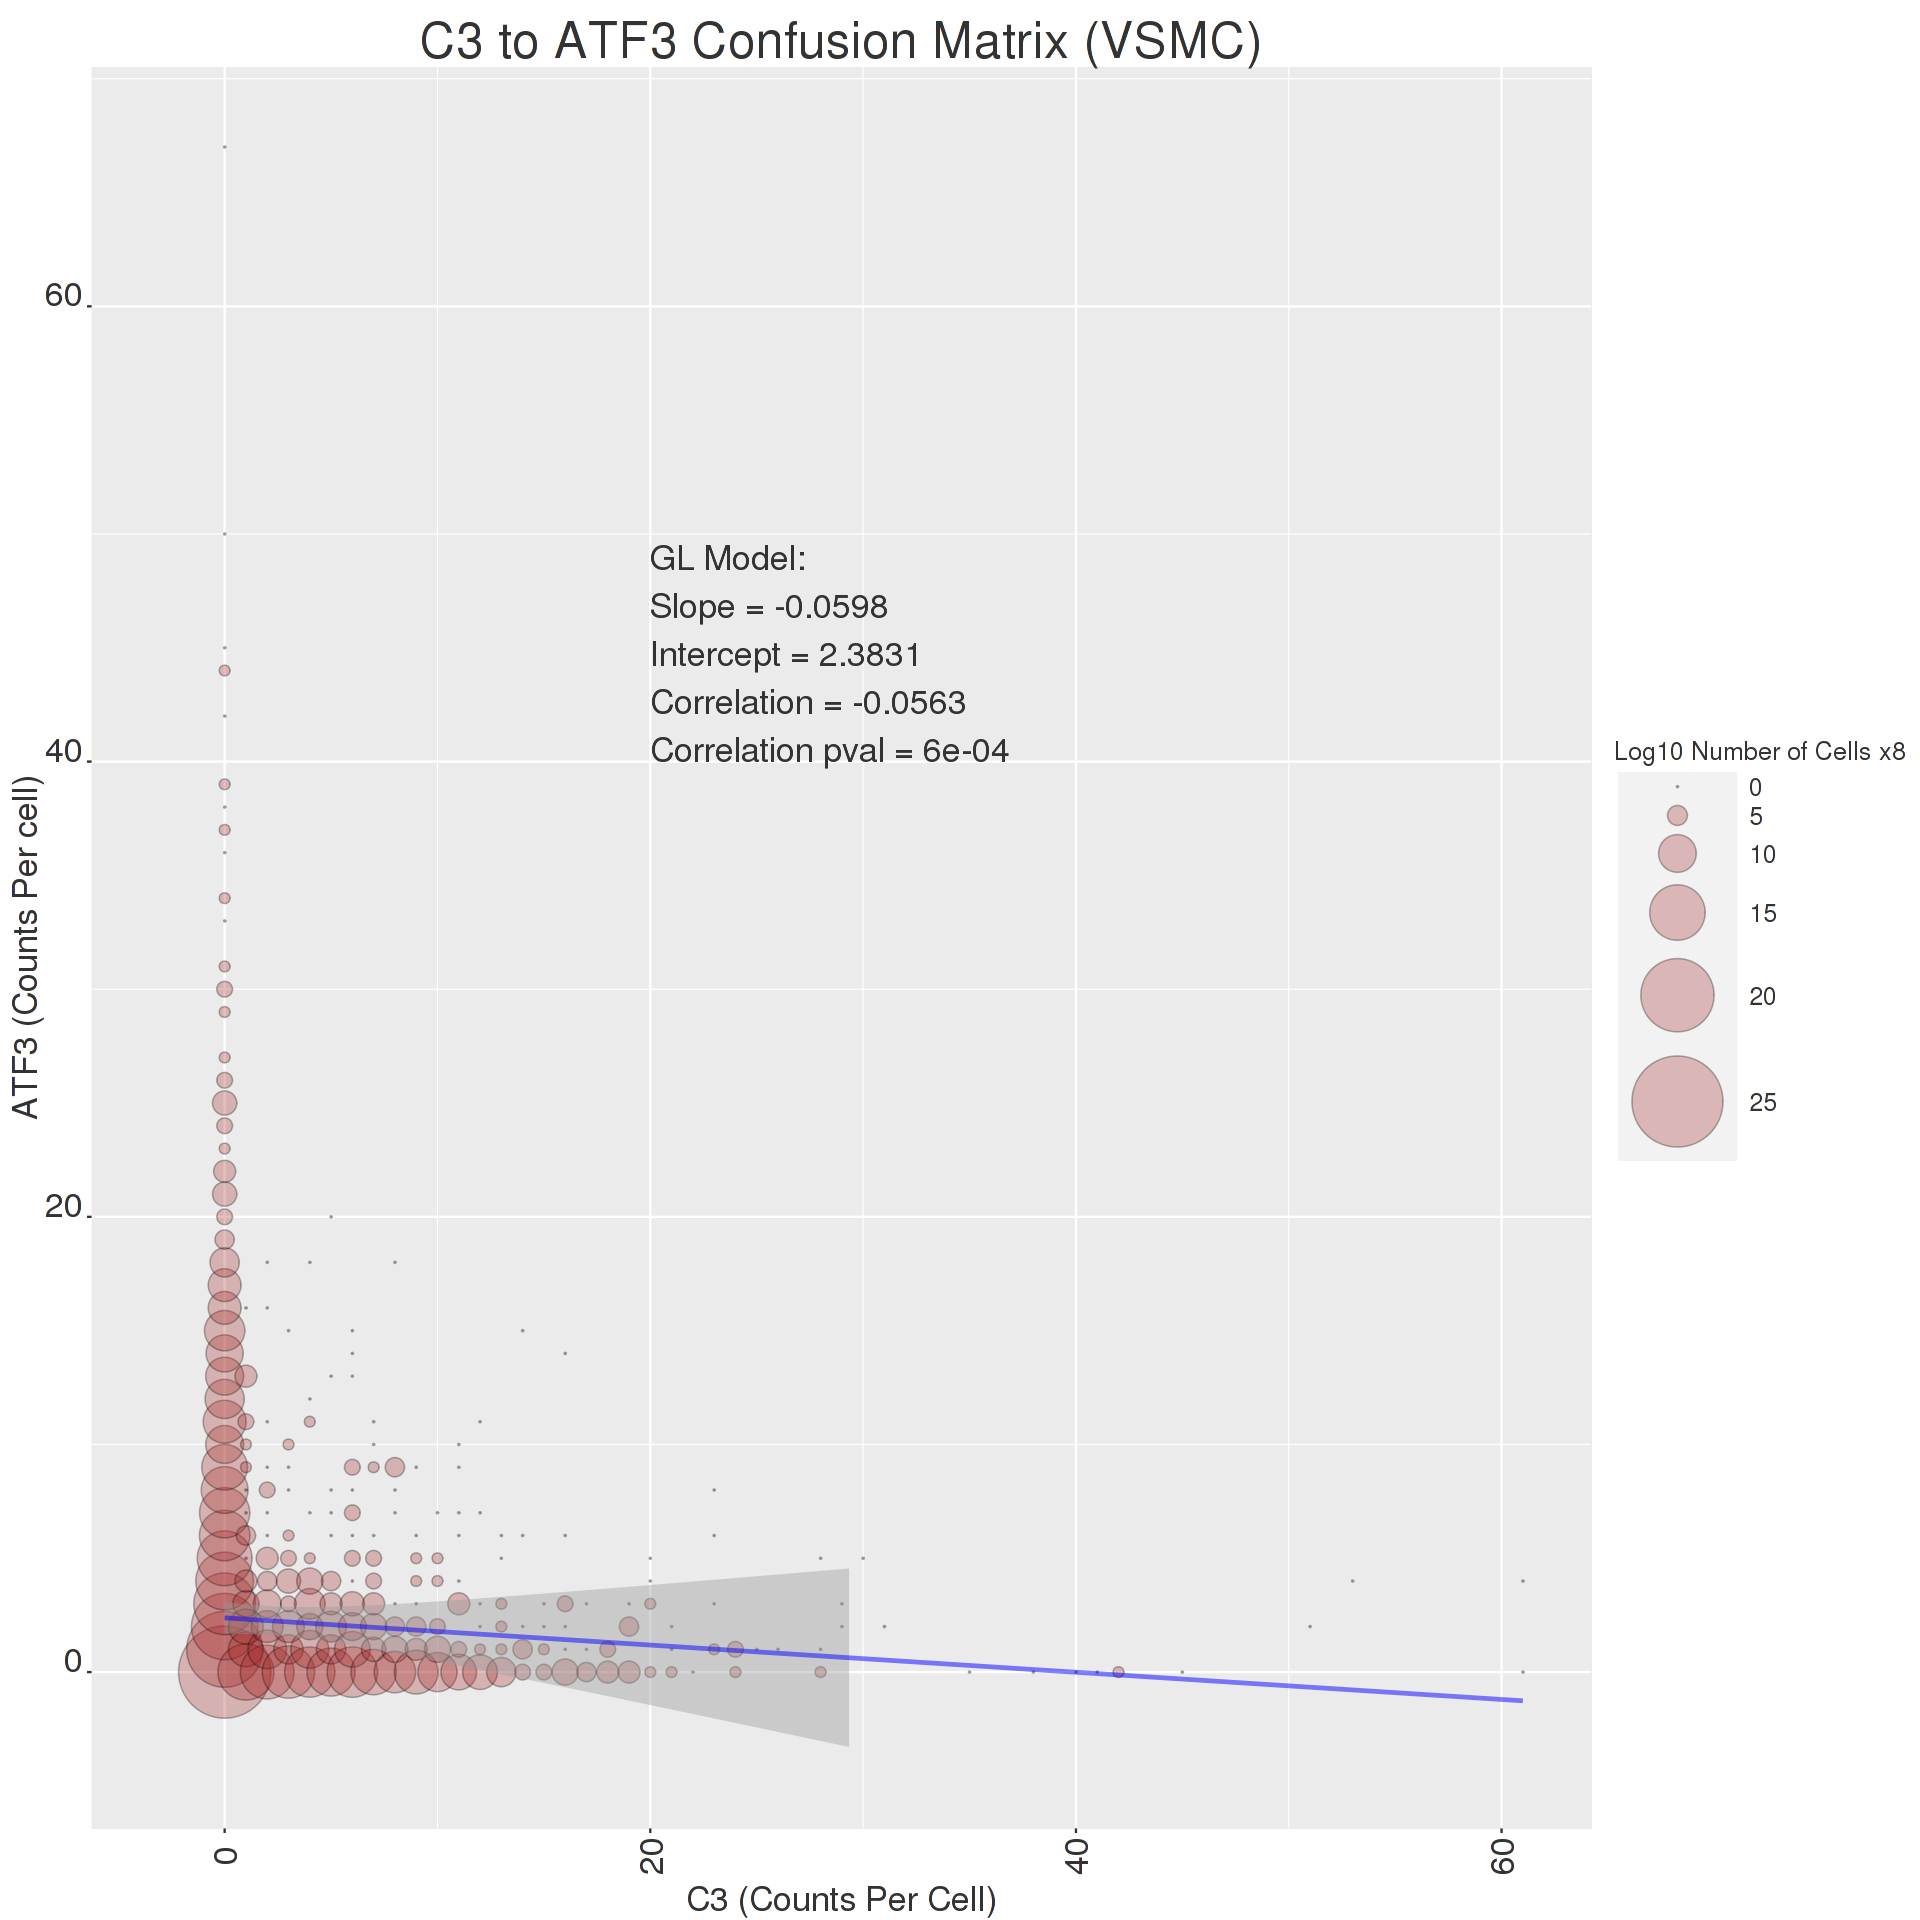

In [493]:
g <- ggplot(conf_xyz_tbl, aes(x = x, y = y, weight = exprs))
g <- g + geom_point(shape = 21, fill = 'brown', alpha = .3, aes(size = logscaled_exp))
g <- g + scale_size_identity(guide = 'legend')
# g <- g + scale_size_area(trans = "identity", guide = 'legend')
g <- g + geom_smooth(formula = y ~ x, method = glm, color = rgb(0,0,1,.5))
g <- g + coord_cartesian(xlim = c(-max_x/20, max_x), ylim = c(-max_y/20, max_y))
g <- g + scale_x_continuous(limits = c(-max_x/20, max_x)) + scale_y_continuous(limits = c(-max_y/20, max_y))
g <- g + labs(x = paste(gene1, ' (Counts Per Cell)', sep = ''),
         y = paste(gene2, ' (Counts Per cell)', sep = ''),
         title = paste(gene1, ' to ', gene2 ,' Confusion Matrix (VSMC)', sep = ''))
g <- g + annotate(geom = 'text', x = 20, y = 40, label = glmtext,
            color = "grey20", size = 7, angle = 0, hjust = 0, vjust = 0)
g <- g + guides(size = guide_legend(title="Log10 Number of Cells x8")) 
g <- g + theme(axis.text.x = element_text(color = "grey20", size = 20, angle = 90, hjust = .5, vjust = .5, face = "plain"),
        axis.text.y = element_text(color = "grey20", size = 20, angle = 0, hjust = 1, vjust = 0, face = "plain"),  
        axis.title.x = element_text(color = "grey20", size = 20, angle = 0, hjust = .5, vjust = 0, face = "plain"),
        axis.title.y = element_text(color = "grey20", size = 20, angle = 90, hjust = .5, vjust = .5, face = "plain"),
        plot.title = element_text(color = "grey20", size = 30, angle = 0, hjust = .5, vjust = 0, face = "plain"),
        legend.text = element_text(color = "grey20", size = 15, angle = 0, hjust = 0, vjust = .5, face = "plain"),
        legend.title = element_text(color = "grey20", size = 15, angle = 0, hjust = .5, vjust = 0, face = "plain"),
        text = element_text(color = "grey20", size = 15, angle = 0, hjust = .5, vjust = 0, face = "plain"))
options(repr.plot.width=16, repr.plot.height=16)
g

In [406]:
f1 <- paste(datdir, '/', ps$outdir, '/VSMC.C3_to_ATF3.Confusion_Matrix.Rev1.pdf', sep = '')
pdf(f1, width = 16, height = 16)
print(g)
dev.off()

png 
  2

In [405]:
paste(datdir, '/', ps$outdir, '/VSMC.C3_to_ATF3.Confusion_Matrix.Rev1.pdf', sep = '')

[1] "/gpfs/group/torkamani/devans/CDC2/outputdat//VSMC.C3_to_ATF3.Confusion_Matrix.Rev1.pdf"

In [ ]:
scale_size_area(trans = "identity")